In [1]:
import numpy as np
import pandas as pd
import json

import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
households = pd.read_csv("../ml-python/data/processed/households_processed.csv")

In [3]:
edges = pd.read_csv("../ml-python/data/processed/edges_processed.csv")

In [4]:
with open("../ml-python/data/processed/flood_scenario_processed.json") as f:
    flood = json.load(f)

In [5]:
print("Households:", households.shape)
print("Edges:", edges.shape)
print("Flood affected households:", len(flood['affected_households']))

Households: (1000, 17)
Edges: (2495, 7)
Flood affected households: 100


In [6]:
G = nx.Graph()

In [7]:
for _, row in households.iterrows():
    G.add_node(
    row['id'],
    need_score=row['need_score'],
    affected=row['affected'],
    severity=row['severity'],
    elderly_count=row['elderly_count'],
    children_count=row['children_count'],
    disability_flag=row['disability_flag'],
    resources_food=row['resources_food'],
    resources_water=row['resources_water'],
    resources_shelter=row['resources_shelter'],
    resources_medicine=row['resources_medicine'],
    marginalized_flag=row['marginalized_flag']
)


In [8]:
for _, row in edges.iterrows():
    G.add_edge(
        row['from_id'],
        row['to_id'],
        tie_strength=row['tie_strength'],
        physical_proximity=row['physical_proximity'],
        kinship_relation=row['kinship_relation'],
        kinship_encoded=row['kinship_encoded'],
        sharing_history=row['sharing_history']
    )

In [9]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 1000
Number of edges: 2495


In [10]:
allocation_plan = []

resources = ['food', 'water', 'shelter', 'medicine']
desired_stock = {'food': 2, 'water': 2, 'shelter': 1, 'medicine': 1}

for node in G.nodes():
    node_data = G.nodes[node]
    if node_data['affected'] == 0:
        continue

    neighbors = list(G.neighbors(node))
    neighbors_sorted = sorted(neighbors, key=lambda n: G[node][n]['tie_strength'], reverse=True)

    allocation = {'to': node}

    allocated_any = False  # Flag to check if any resource was actually allocated

    for r in resources:
        res_col = f'resources_{r}'
        need_amount = max(0, desired_stock[r] - node_data[res_col])
        allocation[f'{r}_allocated'] = 0
        allocation[f'{r}_from'] = None
        allocation[f'{r}_tie_strength'] = None

        if need_amount == 0:
            continue

        for neighbor in neighbors_sorted:
            neighbor_data = G.nodes[neighbor]
            if neighbor_data[res_col] > 0:
                allocation[f'{r}_allocated'] = 1
                allocation[f'{r}_from'] = neighbor
                allocation[f'{r}_tie_strength'] = G[node][neighbor]['tie_strength']
                G.nodes[neighbor][res_col] -= 1
                allocated_any = True
                break

    if allocated_any: 
        allocation_plan.append(allocation)


In [11]:
alloc_df = pd.DataFrame(allocation_plan)
alloc_df.head()

,to,food_allocated,food_from,food_tie_strength,water_allocated,water_from,water_tie_strength,shelter_allocated,shelter_from,shelter_tie_strength,medicine_allocated,medicine_from,medicine_tie_strength
0,H3,1,H169,0.816667,1,H169,0.816667,0,None,NaN,1,H169,0.816667
1,H10,1,H377,0.816667,1,H377,0.816667,0,None,NaN,1,H275,0.800000
2,H11,1,H713,0.983333,1,H713,0.983333,0,None,NaN,1,H276,0.683333
3,H57,1,H847,0.900000,1,H847,0.900000,1,H217,0.766667,0,None,NaN
4,H60,1,H554,0.916667,1,H554,0.916667,0,None,NaN,0,None,NaN


In [13]:
affected_nodes = [n for n, d in G.nodes(data=True) if d['affected']==1]
received_nodes = alloc_df['to'].unique()

In [14]:
fairness_ratio = len(received_nodes) / len(affected_nodes)
print(f"Fairness (coverage of affected households): {fairness_ratio:.2f}")

Fairness (coverage of affected households): 1.00


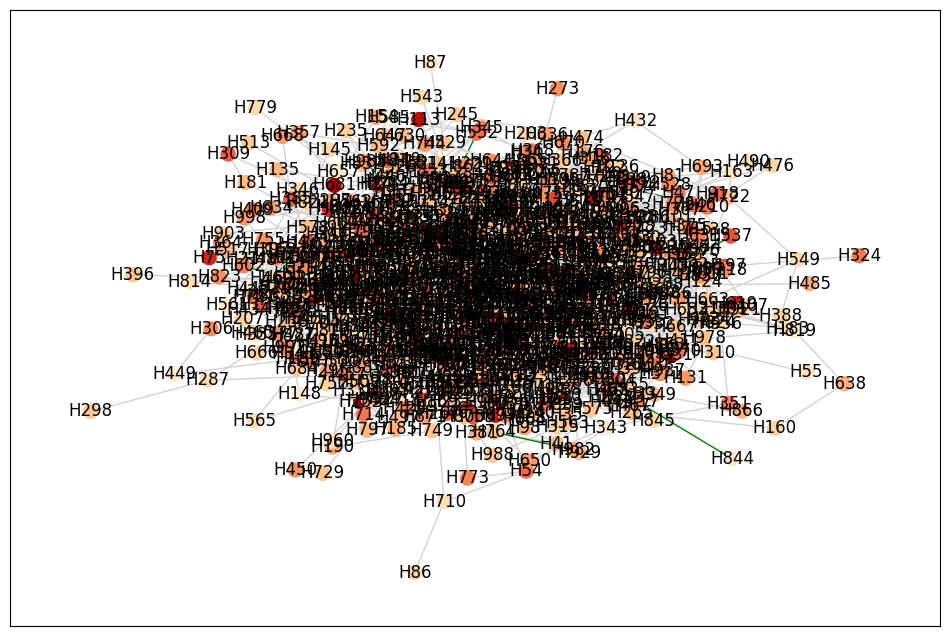

In [18]:
plt.figure(figsize=(12,8))
node_color = [G.nodes[n]['need_score'] for n in G.nodes()]
edge_colors = ['green' if ((alloc_df['food_from']==u)&(alloc_df['to']==v)).any() else 'lightgrey' for u,v in G.edges()]

nx.draw_networkx(
    G,
    node_color=node_color,
    cmap=plt.cm.OrRd,
    with_labels=True,
    edge_color=edge_colors,
    node_size=100
)
# plt.savefig("../outputs/visualizations/allocation_graph.png", dpi=200)
plt.show()


In [12]:
alloc_df.to_csv("../outputs/allocations/allocations_demo.csv" , index = False)

In [20]:
fairness_summary = {
    "total_households": G.number_of_nodes(),
    "affected_households": len(affected_nodes),
    "covered_households": len(received_nodes),
    "coverage_ratio": fairness_ratio
}

In [21]:
pd.DataFrame([fairness_summary]).to_csv(
    "../outputs/reports/fairness_summary.csv",
    index=False
)